#### Real World application 5
You will work on a Twitch dataset. The goal is to learn more about the feat&fun on Twitch. First thing to do is create the network on Neo4j. Insert the node from Twitch/FR_target and then the edges from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries

In [1]:
import py2neo

graph = py2neo.Graph("bolt://localhost:7688", auth=("neo4j", "password_tuts"), name="twitch")
graph.delete_all()

In [2]:
import pandas as pd
import tqdm

target = pd.read_csv("Twitch/FR_target.csv")
target = target.drop_duplicates(subset="id")
target.shape


(6549, 6)

In [3]:
# insertion des nodes

try:
    graph.run("CREATE CONSTRAINT ON (n:Streamer) ASSERT n.id IS UNIQUE")
except:
    print("Constraint already exists")

transaction_list = []
for row in tqdm.tqdm(target.iterrows()):
    id = row[1]["id"]
    days = row[1]["days"]
    mature = row[1]["mature"]
    views= row[1]["views"]
    partner = row[1]["partner"]
    new_id = row[1]["new_id"]
    transaction_list.append({"id": id, "days": days, "mature": mature, "views": views, "partner": partner, "new_id": new_id})
    if len(transaction_list) == 1000:
        transaction = "UNWIND $json as data CREATE (n:Streamer) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []
        
graph.run(transaction, json=transaction_list)

pass

Constraint already exists


0it [00:00, ?it/s]

6549it [00:00, 7905.81it/s]


In [4]:
edges = pd.read_csv("Twitch/FR_edges.csv")
edges = edges.drop_duplicates()
edges.shape

(112666, 2)

In [ ]:
# insertion des relations 
import itertools
import tqdm
graph = py2neo.Graph("bolt://localhost:7688", auth=("neo4j", "password_tuts"), name="twitch")

transaction_list = []
transaction = """UNWIND $json as data
    MATCH (a:Streamer),(b:Streamer)
    WHERE a.new_id = data.from AND b.new_id = data.to
    MERGE (a)-[r:RELATION]->(b)
    ON CREATE
    SET r.n_collab = 1
    ON MATCH
    SET r.n_collab = r.n_collab + 1
    """
it = 0
for edge in tqdm.tqdm(edges.groupby(["from"])):
    related_ids = edge[1]["to"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"from":sh1,"to":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)
pass

In [8]:
# 1.Give the IDs of the top 10 streamers that have atleast one collaboration.

query = """ MATCH (n:Streamer)-[r:RELATION]->(m:Streamer)
WITH n, count(r) as collab
WHERE collab >= 1
RETURN n.id as streamer_id, collab
ORDER BY collab DESC
LIMIT 10
  """

result = graph.run(query).to_data_frame()
print(result)

   streamer_id  collab
0     41719107     847
1    147337432     787
2     24147592     785
3     18887776     734
4     37547034     726
5     41712775     679
6     27085209     671
7     40397145     650
8     70298660     646
9     42347691     644


C:\Users\10144\AppData\Local\Temp\ipykernel_17456\3673739278.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data["degree"],hist=False)


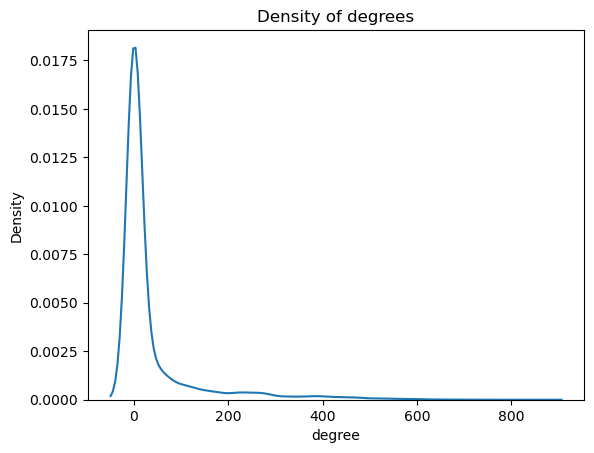

In [9]:
# 2. Create a density of node degrees. Do you observe a power scale law ? What does it mean ?
import seaborn as sns

query =  """
MATCH (s)
WITH s, size(()-[:RELATION]->(s)) as degree
RETURN degree
"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["degree"],hist=False)
ax.title.set_text("Density of degrees")


Yes, we can observe a power scale low, the power-law distribution implies the existence of a small number of highly connected nodes

In [10]:
# 3. How many streamers has the tag "mature" ?

query = """ MATCH (n:Streamer)
            WHERE n.mature = True
            RETURN count(n) as mature_streamers """

result = graph.run(query).to_data_frame()
print(result)

   mature_streamers
0              2414


In [27]:
# 4. Is the collaboration correlated to the "mature" tag ?

query = """MATCH (s:Streamer)-[r:RELATION]->()
WITH s.mature AS mature, count(r) AS collab_count
RETURN mature, collab_count
 """

result = graph.run(query).to_data_frame()
corr = result['mature'].corr(result['collab_count'])
print(result)
print(corr) 

   mature  collab_count
0   False        147018
1    True        104530
-0.9999999999999999


Le coefficient de corrélation entre le nombre de collaboration et 'mature' label est tend vers -1, cela signifie qu'il existe une corrélation négative, les streamers sans le label 'mature' tendent d'avoir plus de collaboration

In [23]:
# 5. Do partners collaborate more than non partners ?

query = """ MATCH (n:Streamer)-[r:RELATION]->(m:Streamer)
WHERE n <> m AND n.partner = True AND m.partner = True
RETURN count(r) as collab_p """

result1 = graph.run(query).to_data_frame()
print(result1)

query2 = """ MATCH (n:Streamer)-[r:RELATION]->(m:Streamer)
WHERE n <> m AND n.partner = False AND m.partner = False
RETURN count(r) as collab_np """

result2 = graph.run(query2).to_data_frame()
print(result2)

if result1["collab_p"][0] > result2["collab_np"][0]:
    print("Partners collaborate more than non partners")
else:
    print("Non partners collaborate more than partners")

   collab_p
0     15077
   collab_np
0     156374
Non partners collaborate more than partners
